# Assignment 2: Evaluating and Extending an RNN based Part-of-Speech Tagger

Extensions 1 (GRU), 2 (bidirectional), 3 (`Dataset` and `Dataloader` class) and 8 (universal vs language specific POS tags) are implemented.


## Before starting

Some installations and imports.

In [1]:
pip install conllu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Our standard imports for maths and basic methodology
import numpy as np
# from sklearn.model_selection import train_test_split 

# For downloading and parsing the datasets
import os
from conllu import parse
import glob

# For user feedback
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import pandas as pd
from collections import defaultdict

# Imports for pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [3]:
if torch.cuda.is_available():
  for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))
else:
  print("No GPU available")

Tesla T4


## Load and format tagging data

The training and test sets of three treebanks are loaded to a newly created directory.

Functions are created to extract the sentences and POS tags from the loaded UD data and to show some simple information of the treebanks. 

Here we pick Vietnamese, English and Finnish as representatives of morphologically poor to morphologically rich languages.

In [4]:
if "data" not in os.listdir():
  os.mkdir("data")

treebanks = {'UD_English-GUM': ['en_gum-ud-train.conllu', 'en_gum-ud-test.conllu'], 
             'UD_Finnish-TDT': ['fi_tdt-ud-train.conllu', 'fi_tdt-ud-test.conllu'],
             'UD_Vietnamese-VTB': ['vi_vtb-ud-train.conllu', 'vi_vtb-ud-test.conllu'],}
for treebank in treebanks:
  for dataset in treebanks[treebank]:
    url = f"https://raw.githubusercontent.com/UniversalDependencies/{treebank}/master/{dataset}"
    !wget --no-cache -N -P data {url}


--2022-06-15 13:01:25--  https://raw.githubusercontent.com/UniversalDependencies/UD_English-GUM/master/en_gum-ud-train.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10998186 (10M) [text/plain]
Saving to: ‘data/en_gum-ud-train.conllu’

en_gum-ud-train.con 100%[===================>]  10.49M  --.-KB/s    in 0.03s   

Last-modified header missing -- time-stamps turned off.
2022-06-15 13:01:25 (310 MB/s) - ‘data/en_gum-ud-train.conllu’ saved [10998186/10998186]

--2022-06-15 13:01:26--  https://raw.githubusercontent.com/UniversalDependencies/UD_English-GUM/master/en_gum-ud-test.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githu

The `UDDataset` from the `Dataset` class. The `pad_and_encode` method is moved here to be used in our dataloader.

In [5]:
class UDDataset(Dataset):
  def __init__(self, language_code, train_or_test, pos="upos"):
    '''Parses the conllu format and returns lists of sentences and their corresponding POS tags. '''
    file_list = glob.glob(f"./data/{language_code}*{train_or_test}.conllu")
    data = open(file_list[0], mode="r", encoding="utf-8")
    annotations = data.read()
    sents = parse(annotations)                                                  # list of TokenLists

    # iterate through the TokenList format of sentences to get tuples of each word and its POS tag
    sentences = []
    for sent in sents:
      if len(sent) > 2:
        sentence = [(word['form'], word[pos]) for word in sent]
        sentences.append(sentence)

    # put the words in a list and their tags in another
    self.X = [[token for token, tag in sentence] for sentence in sentences]
    self.y = [[tag for token, tag in sentence] for sentence in sentences]
    self.X, self.y = self.X[:10000], self.y[:10000]                             # length capped for our selected treebanks
 
  def __len__(self):
    assert len(self.X) == len(self.y)
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

  def pad_and_encode(self, data):
    '''Pads and encodes the sentences and labels. '''
    sentences, labels = zip(*data)
    assert len(sentences)==len(labels)
    assert np.all([len(sentence)==len(tags) for sentence, tags in zip(sentences, labels)])
    max_sentence_length = np.max([len(sentence) for sentence in sentences]) 
    padded_sentences = torch.zeros(len(sentences), max_sentence_length,         # Create data structures with <PAD> as default
                                  dtype=torch.long)
    padded_sentences[:] = token2idx['<PAD>']
    padded_labels = torch.zeros(len(sentences), max_sentence_length, 
                                dtype=torch.long)
    padded_labels[:] = tag2idx['<PAD>']
    for i, (sentence, tags) in enumerate(zip(sentences, labels)):               # Loop over the data
      for j, token in enumerate(sentence):
        if token in token2idx.keys():
          padded_sentences[i, j] = token2idx[token]
        else:
          padded_sentences[i, j] = token2idx['<UNK>']
      for j, tag in enumerate(tags):
        if tag in tag2idx.keys():
          padded_labels[i, j] = tag2idx[tag]
        else:
          padded_labels[i, j] = tag2idx['<UNK>']                                # Unseen tags
    if torch.cuda.is_available():
      return padded_sentences.cuda(), padded_labels.cuda()
    return padded_sentences, padded_labels

In [6]:
def inspect(language, X_train, X_test):
  ''' Prints the no. of sentences in the datasets and plots their sentence length distribution. '''
  print(f"The training set of {language} includes {len(X_train)} sentences")
  print(f"The test set of {language} includes {len(X_test)} sentences")
  l = np.asarray([len(x) for x in X_train], dtype=int)
  plt.figure(figsize=(8, 4))
  x = np.unique(l)
  plt.bar(x, [np.sum(l==e) for e in x], width=1)
  plt.xlabel("Sentence length")
  plt.ylabel("# sentences")
  plt.show()

## Data encoding and padding

Build lookup tables for our tokens and tags.

In [7]:
def lut(X_train, y_train):
  '''Pads the data and returns lookup tables for our tokens and tags. '''
  tokens = {token for sentence in X_train for token in sentence}
  idx2token = list(tokens)
  idx2token.insert(0, '<UNK>')      # deal with OOV words
  idx2token.append('<PAD>')
  token2idx = {token:idx for idx, token in enumerate(idx2token)}

  tags = {tag for tags in y_train for tag in tags}
  idx2tag = list(tags)
  idx2tag.append('<PAD>')
  idx2tag.append('<UNK>')           # account for unseen tags
  tag2idx = {tag:idx for idx, tag in enumerate(idx2tag)}
  return token2idx, tag2idx, idx2token, idx2tag

## Model

Our model is built as the `Tagger` class here. 

Most of the originaly provided comments are deleted for the purpose of this assignment.

In [8]:
class Tagger(nn.Module):
  def __init__(self, word_embedding_dim, hidden_dim, vocabulary_size, tagset_size, lstm_gru='LSTM', bidirectional=True):
    """A LSTM/GRU based tagger
    
    word_embedding_dim
      The dimensionality of the word embedding
    hidden_dim
      The dimensionality of the hidden state in the LSTM or GRU
    vocabulary_size
      The number of unique tokens in the word embedding (including <PAD> etc)
    tagset_size
      The number of unique POS tags
    lstm_gru
      The type of model, can take 'LSTM' or 'GRU'
    bidirectional
      Bidirectionality of the model, Boolean default as True
    """
    super().__init__()            
    self.hidden_dim_ = hidden_dim                           
    self.vocabulary_size_ = vocabulary_size
    self.tagset_size_ = tagset_size
    self.batch_size = 256
    self.epochs = 5
    self._word_embedding = nn.Embedding(num_embeddings=vocabulary_size,         
                                         embedding_dim=word_embedding_dim, 
                                         padding_idx=token2idx['<PAD>'])
    self._tagger = getattr(nn, lstm_gru)(input_size=word_embedding_dim,          
                         hidden_size=hidden_dim,                           
                         batch_first=True, bidirectional=bidirectional)
    if bidirectional:
      self._fc = nn.Linear(hidden_dim*2, tagset_size)                           # The dimensionality of the hidden state has to double for bidirectionality
    else:
      self._fc = nn.Linear(hidden_dim, tagset_size)
    self._softmax = nn.LogSoftmax(dim=1)                                        
    
    self.training_loss_ = list()                                                # For plotting
    self.training_accuracy_ = list()

    if torch.cuda.is_available():                                               # Move the model to the GPU if available
      self.cuda()

  def forward(self, padded_sentences):
    """The forward pass through the network"""
    batch_size, max_sentence_length = padded_sentences.size()

    embedded_sentences = self._word_embedding(padded_sentences)                    

    sentence_lengths = (padded_sentences!=token2idx['<PAD>']).sum(dim=1)        
    sentence_lengths = sentence_lengths.long().cpu()                            
    X = nn.utils.rnn.pack_padded_sequence(embedded_sentences, sentence_lengths, # Pack the embedded data
                                          batch_first=True, enforce_sorted=False)
    tagger_out, _ = self._tagger(X)                                             # Run the layer
    X, _ = nn.utils.rnn.pad_packed_sequence(tagger_out, batch_first=True)       # Unpack the output

    X = X.contiguous().view(-1, X.shape[2])                                     # Flatten the output
    tag_space = self._fc(X)                                                     # Fully connected layer
    tag_scores = self._softmax(tag_space)                                       # Apply softmax
    return tag_scores.view(batch_size, max_sentence_length, self.tagset_size_)

  def fit(self, dataset):
    loss_function = nn.NLLLoss(ignore_index=tag2idx['<PAD>'])                                                                                                  
    optimizer = torch.optim.Adam(self.parameters(), lr=0.01)                                                                                      
    for epoch in range(self.epochs):                                            
      for inputs, targets in DataLoader(dataset=dataset, batch_size=self.batch_size, 
                                        shuffle=True, collate_fn=dataset.pad_and_encode):                                            
        self.zero_grad()                                                        
        scores = self(inputs)                                                   # Forward pass
        loss = loss_function(scores.view(-1, self.tagset_size_),              
                            targets.view(-1))               
        loss.backward()                                                         # Backpropagate the error
        optimizer.step()                                                       
        predictions = scores.argmax(dim=2, keepdim=True).squeeze()             
        mask = targets!=tag2idx['<PAD>']                                         
        correct = (predictions[mask] == targets[mask]).sum().item()            
        accuracy = correct / mask.sum().item()*100
        self.training_accuracy_.append(accuracy)                              
        self.training_loss_.append(loss.item())                               

  def score(self, dataset):
    with torch.no_grad():                                                          
      n_correct = 0
      n_total = 0
      for inputs, targets in DataLoader(dataset=dataset, batch_size=self.batch_size, 
                                        shuffle=True, collate_fn=dataset.pad_and_encode):
        scores = self(inputs)                                                      
        predictions = scores.argmax(dim=2, keepdim=True).squeeze()                 
        mask = targets!=tag2idx['<PAD>']                                          
        n_correct += (predictions[mask] == targets[mask]).sum().item()            
        n_total += mask.sum().item()
    return 100*n_correct/n_total

## Run the model on our treebanks

The model is first fun on the given model for our baseline accuracy (unidirectional LSTM). Then the model is run on the three treebanks with the settigns of bi-LSTM, and uni- and bi-directional GRU.

In [11]:
languages = {'vi': 'Vietnamese', 'en': 'English', 'fi': 'Finnish'}
binary_features = ['Baseline', 'GRU', 'bi-LSTM', 'bi-GRU']
table = {feature: [] for feature in binary_features}

for language in languages:
  train_dataset = UDDataset(language, 'train')
  test_dataset = UDDataset(language, 'test')
  for feature in table:
    print(f'Modelling {languages[language]} with {feature}...')
    rnn_type, bi = 'LSTM', False     # baseline settings
    if 'GRU' in feature:
      rnn_type = 'GRU'
    if 'bi-' in feature:
      bi = True

    token2idx, tag2idx, idx2token, idx2tag = lut(train_dataset.X, train_dataset.y)
    model = Tagger(word_embedding_dim=32,                                               # Dimensionality of the word embedding
                      hidden_dim=64,                                                    # Dimensionality of the hidden state in the LSTM/GRU
                      vocabulary_size=len(token2idx),                                   # The vocabulary incudes both the 'padding' and 'unknown' symbols
                      tagset_size=len(tag2idx)-1, lstm_gru=rnn_type, bidirectional=bi)  # We have no interest in the network outputting the padding symbol
    model.fit(train_dataset)
    table[feature].append(round(model.score(test_dataset), 2))

df = pd.DataFrame(table, index=languages.values())

Modelling Vietnamese with Baseline...
Modelling Vietnamese with GRU...
Modelling Vietnamese with bi-LSTM...
Modelling Vietnamese with bi-GRU...
Modelling English with Baseline...
Modelling English with GRU...
Modelling English with bi-LSTM...
Modelling English with bi-GRU...
Modelling Finnish with Baseline...
Modelling Finnish with GRU...
Modelling Finnish with bi-LSTM...
Modelling Finnish with bi-GRU...


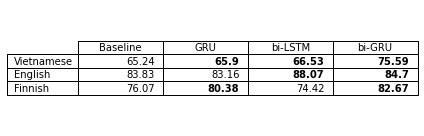

In [12]:
#define figure and axes
fig, ax = plt.subplots(figsize=(6, 2))
#hide the axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

#create table
binary_table = ax.table(cellText=df.values, rowLabels=df.index, colLabels=df.columns, loc='center')

# bold results that are better than our basline
for i, c in enumerate(df):
  for j, v in enumerate(df[c]):
    if v > df['Baseline'][j]:
      binary_table[(j+1, i)].get_text().set_weight('bold') # SET FONT

#display table
fig.tight_layout()
plt.show()

Bolded scores are better performers compared to the basline. As shown above, a bi-GRU model shows a better performance overall (although it is sometimes  on par with bi-LSTM for English and Finnish after several runs). 
The benefit of bidirectionality is the clearest with Vietnamese. It may be because morphologically poor (or analytic) languages rely more heavily on particles and word order instead of inflections to determine word classes, and bidirectional information gives us a stronger hint on word order.

Let's use that to look at universal and language specific tags.

In [13]:
from math import sqrt
languages = {'vi': 'Vietnamese', 'en': 'English', 'fi': 'Finnish'}
pos_table = defaultdict(list)

for language in languages:
  for pos in ('upos','xpos'):
    print(f'Tagging {languages[language]} with {pos}...')
    train_dataset = UDDataset(language, 'train', pos=pos)
    test_dataset = UDDataset(language, 'test', pos=pos)
    token2idx, tag2idx, idx2token, idx2tag = lut(train_dataset.X, train_dataset.y)
    model = Tagger(word_embedding_dim=32,                                              
                      hidden_dim=64,                                                 
                      vocabulary_size=len(token2idx),                                  
                      tagset_size=len(tag2idx)-1, lstm_gru='GRU', bidirectional=True)   
    model.fit(train_dataset)
    index = int(len(model.training_accuracy_)*(5/model.epochs))-1
    pos_table[pos].append(round(model.score(test_dataset), 2))

pos_df = pd.DataFrame(pos_table, index=languages.values())
print(pos_df)

Tagging Vietnamese with upos...
Tagging Vietnamese with xpos...
Tagging English with upos...
Tagging English with xpos...
Tagging Finnish with upos...
Tagging Finnish with xpos...
             upos   xpos
Vietnamese  73.38  66.58
English     89.19  85.93
Finnish     75.85  87.24


The accuracy for Vietnamese is higher with universal tags, while that for Finnish is higher with language specific tags. For English, using universal tags has a higher accuracy, but over several runs the accuracy of using the two sets of tags are similar.
We can speculate that since morphologically rich languages like Finnish store more complex grammatical information in a word, it is helpful to establish more intricate POS tags that more accurately describe the grammatical roles in words, and tagging with such tags will yield a higher accuracy.

Let's look at how the number of dimensions can affect our results. We vary the word embedding or hidden dimensions between 32 and 64, so we get a set of 4 results per language.

In [19]:
languages = {'vi': 'Vietnamese', 'en': 'English', 'fi': 'Finnish'}
# dim_results = {'word embedding dimensions': {}, 'hidden dimensions': {}}
dims = [32, 64]
for language in languages:
  for i in dims:
    for j in dims:
      print(f'Tagging {languages[language]} with {i} word embedding dimensions & {j} hidden dimensions...')
      train_dataset = UDDataset(language, 'train')
      test_dataset = UDDataset(language, 'test')
      token2idx, tag2idx, idx2token, idx2tag = lut(train_dataset.X, train_dataset.y)
      model = Tagger(word_embedding_dim=i,                                              
                        hidden_dim=j,                                                 
                        vocabulary_size=len(token2idx),                                  
                        tagset_size=len(tag2idx)-1, lstm_gru='GRU', bidirectional=True)   
      model.fit(train_dataset)
      print(round(model.score(test_dataset), 2))

Tagging Vietnamese with 32 word embedding dimensions & 32 hidden dimensions...
72.0
Tagging Vietnamese with 32 word embedding dimensions & 64 hidden dimensions...
71.75
Tagging Vietnamese with 64 word embedding dimensions & 32 hidden dimensions...
68.54
Tagging Vietnamese with 64 word embedding dimensions & 64 hidden dimensions...
75.21
Tagging English with 32 word embedding dimensions & 32 hidden dimensions...
84.98
Tagging English with 32 word embedding dimensions & 64 hidden dimensions...
87.51
Tagging English with 64 word embedding dimensions & 32 hidden dimensions...
88.85
Tagging English with 64 word embedding dimensions & 64 hidden dimensions...
89.81
Tagging Finnish with 32 word embedding dimensions & 32 hidden dimensions...
70.14
Tagging Finnish with 32 word embedding dimensions & 64 hidden dimensions...
78.9
Tagging Finnish with 64 word embedding dimensions & 32 hidden dimensions...
75.66
Tagging Finnish with 64 word embedding dimensions & 64 hidden dimensions...
84.33


It is obvious that a higher number of dimensions increases our POS tagging accuracy, but the impact is the strongest in Finnish (70.14% -> 84.33%) compared to Vietnamese (72.0% -> 75.21%) and English (84.98% -> 89.81%). This trend indicates that having more dimensions are especially helpful for tagging morphologically rich languages. It is also interesting to see that  increasing only either of the word embedding dimensions or the hidden dimensions are not conducive at all.

### Comments

Given the code for the tagger, implementing GRU, bidirectionality and other things are relatively straightforward. It is interesting to see how structures in our neural network can significantly affect performance for language tasks (POS tagging in this case), and that the impact has a clear trend across morphological richness. 

It was a bit challenging to start working on this assignment in the beginning, since this is the first time we use PyTorch, and implementing the `Dataset` and `Dataloader` and putting the padding and encoding process took a while before getting used to it.